# Image classifier

### Neural Networks
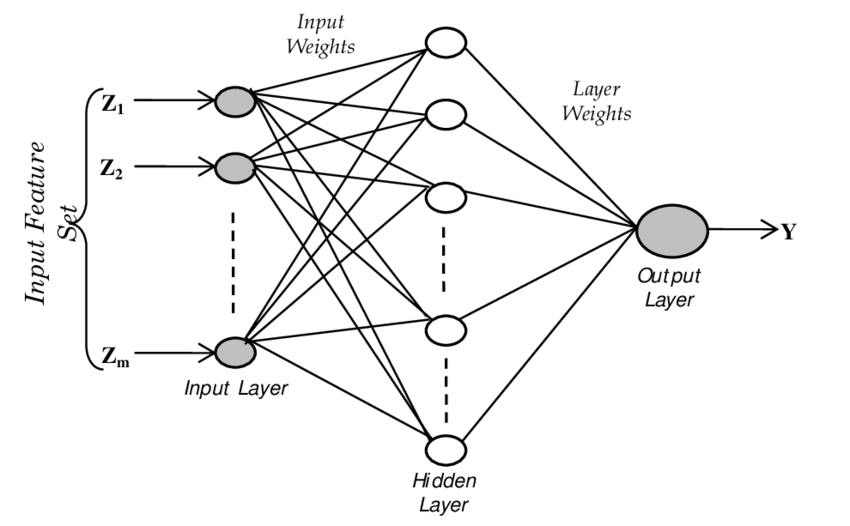

### 1. Setup and Load data

In [7]:
#installing the dependencies //tensorflow-gpu is not supported by python 3.11
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached matplotlib-3.8.2-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp311-cp311-win_amd64.whl (2.7 MB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl (938 kB)
  Using cached numpy-1.26.2-cp311-cp311-win_amd64.whl (15.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Using cached protobuf-4.25.1-cp310-abi3-win_amd64.whl (413 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached grpcio-1.60.0-cp311-cp311-win_amd64.whl (3.7 MB)
  U


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# importing the dependencies
import tensorflow as tf
import os

In [2]:
# to not use all of the memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Remove dodgy images

In [3]:
import cv2

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
from PIL import Image
import io

def get_image_type(image_path):
    try:
        with open(image_path,'rb') as f:
            image_data = f.read()
        image = Image.open(io.BytesIO(image_data))
        return image.format.lower()
    except Exception as e:
        print(f"Error: {e}")
        return None

In [7]:
other = []

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = get_image_type(image_path)
            if tip not in image_exts:
                print('Images not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('issue with the image {}'.format(image_path))

#### Examples

In [9]:
#finding the number of images in the cat folder
image_list = []
dir_cat = os.path.join('data','cat')
for img in os.listdir(dir_cat):
    image_list.append(img)
print(len(image_list))

153


In [10]:
cat_image = cv2.imread(os.path.join(data_dir,'cat','1200px-Cat03.jpg'))

In [11]:
cat_image.shape

(1199, 1200, 3)

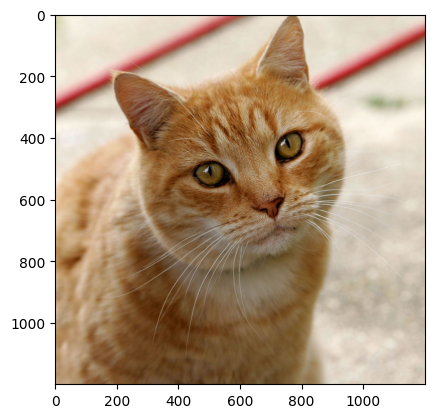

In [13]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(cat_image,cv2.COLOR_BGR2RGB))
plt.show()

### Load data

In [14]:
## tensorflow has a dataset api
tf.data.Dataset??

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size = 32)

Found 405 files belonging to 2 classes.


In [17]:
# this is actually a gnerator
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
#batch[0] has all the images
#batch[1] has all the labels(class) of the image data
# 32 images per batch
batch = data_iterator.next()
print(len(batch[1]))
print(batch[0].shape)

32
(32, 256, 256, 3)


In [20]:
# class 1 => dog
# class 2 => cat
batch[1]

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0])

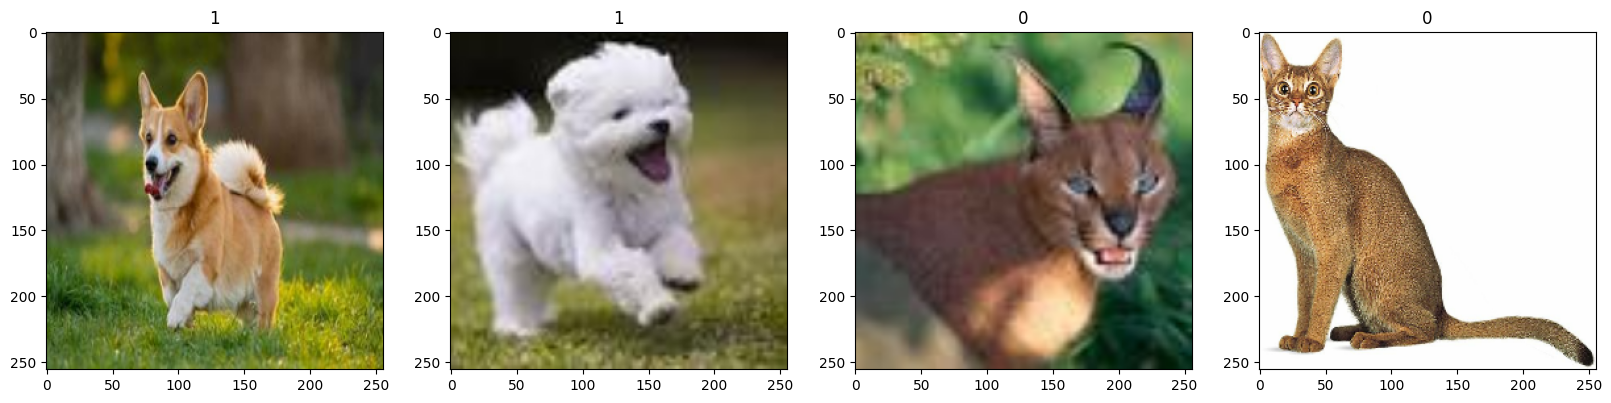

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### 2. Preprocess Data

### Scale Data

In [22]:
# x is the image y is the target variable (= labels)
data = data.map(lambda x,y:(x/255,y))

In [23]:
data_iterator = data.as_numpy_iterator()

In [24]:
batch = data_iterator.next()

In [25]:
batch[0].max()

1.0

### Split Data

In [26]:
len(data) #number of batches

13

In [27]:
train_size = int(13*0.7) # train the data
val_size = int(13*0.2)+1 # evaluate while training
test_size = int(13*0.1) # test the data

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### 3. Deep Model

### 3.1 Build the deep learning model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [42]:
model = Sequential()

In [43]:
# adds convolution layer and a maxpooling layer input layer
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())


model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 16)       

### 3.2 Train

In [47]:
logdir = 'logs'

In [49]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [50]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20


9/9 [==============================] - 8s 546ms/step - loss: 0.9597 - accuracy: 0.4306 - val_loss: 0.6847 - val_accuracy: 0.6250
Epoch 2/20
9/9 [==============================] - 6s 523ms/step - loss: 0.6744 - accuracy: 0.6319 - val_loss: 0.6147 - val_accuracy: 0.6667
Epoch 3/20
9/9 [==============================] - 6s 509ms/step - loss: 0.6540 - accuracy: 0.6285 - val_loss: 0.6474 - val_accuracy: 0.6146
Epoch 4/20
9/9 [==============================] - 6s 538ms/step - loss: 0.6274 - accuracy: 0.6493 - val_loss: 0.5973 - val_accuracy: 0.6979
Epoch 5/20
9/9 [==============================] - 6s 503ms/step - loss: 0.6032 - accuracy: 0.6771 - val_loss: 0.5481 - val_accuracy: 0.6979
Epoch 6/20
9/9 [==============================] - 6s 514ms/step - loss: 0.5890 - accuracy: 0.6632 - val_loss: 0.5897 - val_accuracy: 0.6458
Epoch 7/20
9/9 [==============================] - 6s 531ms/step - loss: 0.4923 - accuracy: 0.7326 - val_loss: 0.5148 - val_accuracy: 0.7188
Epoch 8/20
9/9 [==

### 3.3 Plot Preference
##### If you see loss decreasing and the validation loss rising up that, that is an indication of overfitting
##### If you see the loss not decreasing at all that means the neural network is not able to learn (there could be biases)

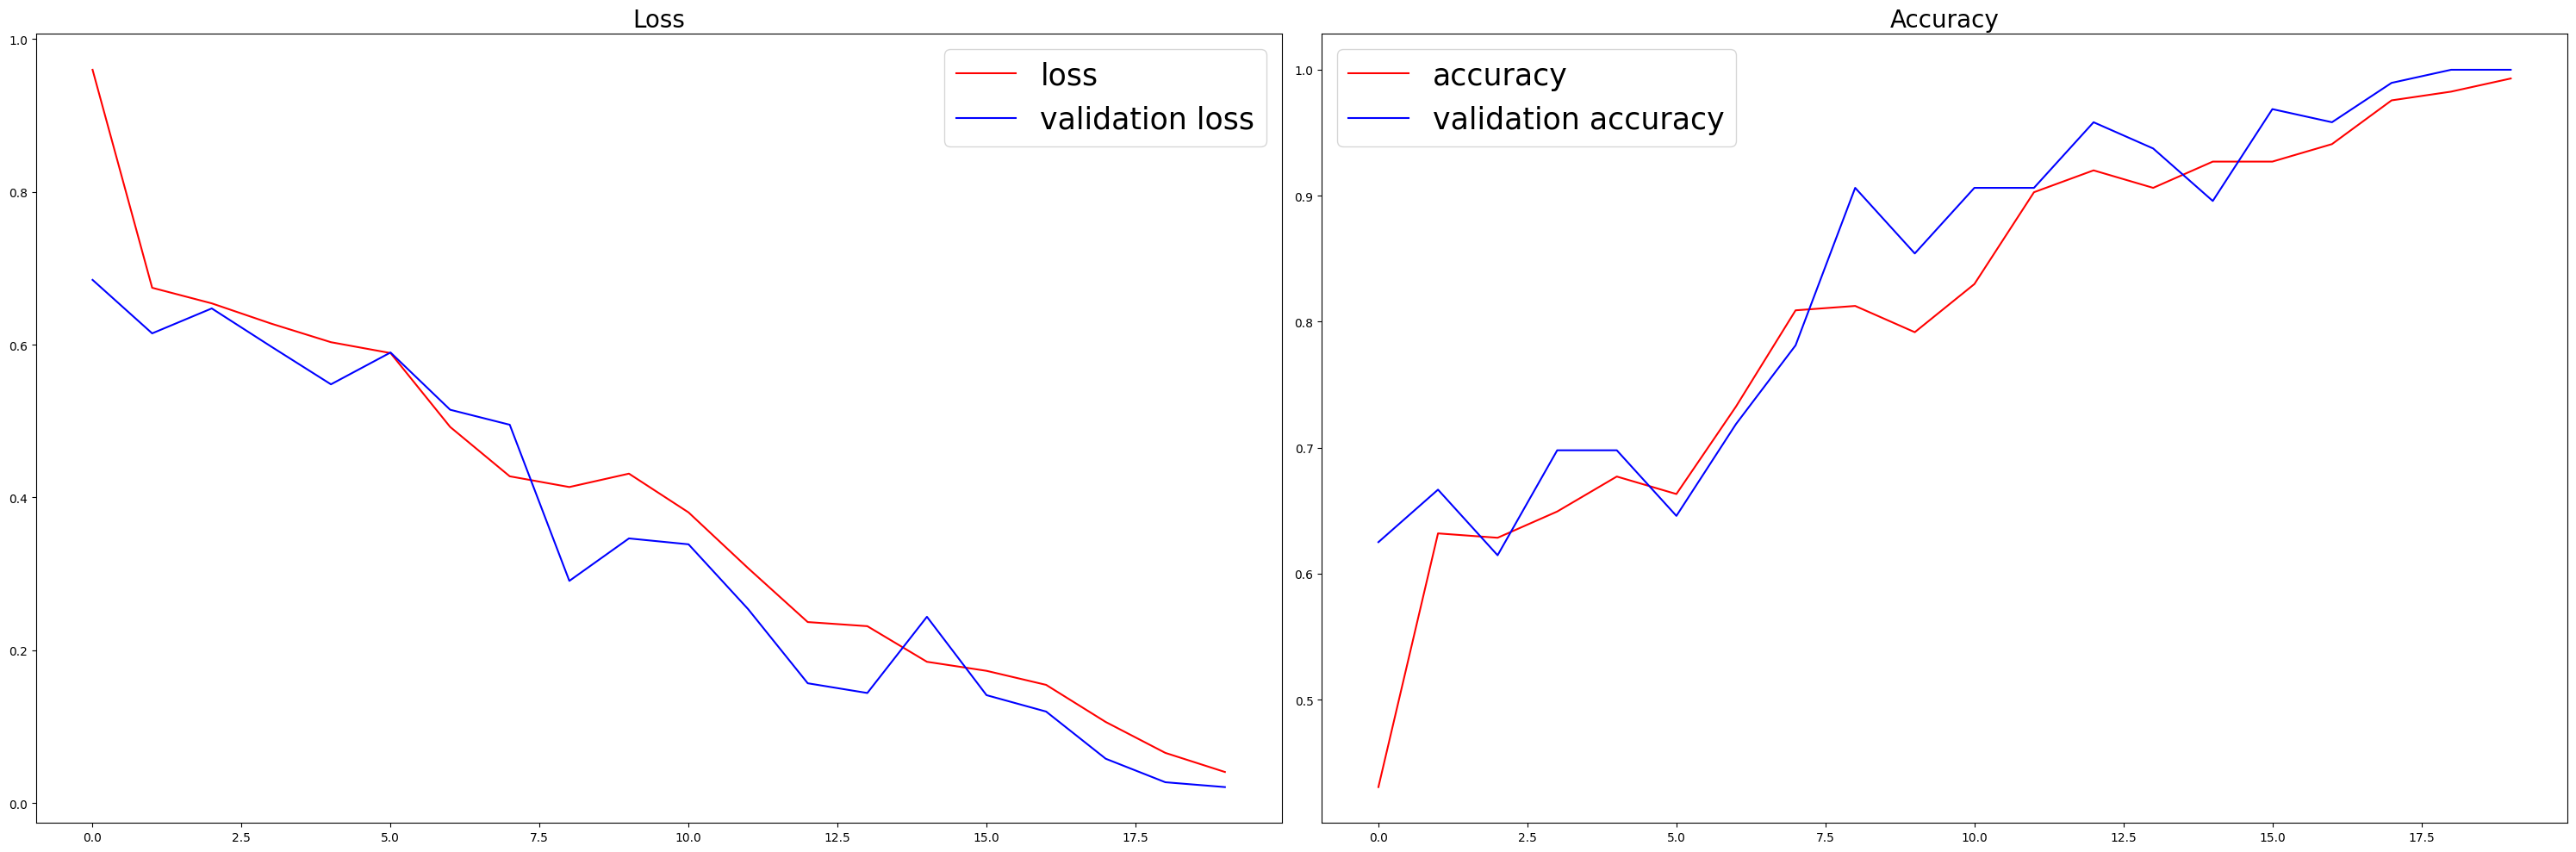

In [81]:
figure, axis = plt.subplots(1, 2, figsize=(30,10))

axis[0].plot(hist.history['loss'], color='red', label='loss')
axis[0].plot(hist.history['val_loss'], color='blue', label='validation loss')
axis[0].set_title('Loss', fontsize=20)
axis[0].legend(loc='upper right', fontsize=25)

axis[1].plot(hist.history['accuracy'], color='red', label='accuracy')
axis[1].plot(hist.history['val_accuracy'], color='blue', label='validation accuracy')
axis[1].set_title('Accuracy', fontsize=20)
axis[1].legend(loc='upper left', fontsize=25)

plt.tight_layout()
plt.show()

### 4. Evaluate the Performance

### 4.1 Evaluate

In [82]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [83]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [88]:
for batch in test.as_numpy_iterator():
    X, Y = batch
    #print(Y)
    yhat = model.predict(X)
    #print(yhat)
    pre.update_state(Y, yhat)
    re.update_state(Y, yhat)
    acc.update_state(Y, yhat)

1/1 [==============================] - 0s 67ms/step


In [90]:
print(f'Precision = {pre.result().numpy()}\nRecall = {re.result().numpy()}\nAccuracy = {acc.result()}')

Precision = 1.0
Recall = 1.0
Accuracy = 1.0


### 4.2 Test

In [93]:
import cv2
import os

#### 4.2.1 Test 1

In [102]:
directory = 'test_cat'
test_cat_img = os.listdir(directory)[0]
img_path = os.path.join(directory,test_cat_img)
img_path

'test_cat\\cat.jpg'

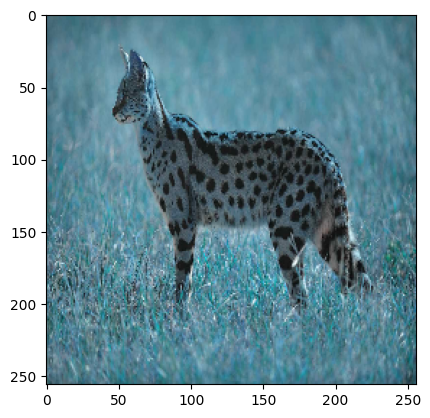

In [109]:
# the image needs to be resized to (256, 256) before it is sent as input to the neural network
cat = cv2.imread(img_path)
resized_img = tf.image.resize(cat, (256,256))
image = resized_img.numpy().astype(int)
plt.imshow(image)
plt.show()

In [122]:
resized_img.shape

TensorShape([256, 256, 3])

In [121]:
np.expand_dims(resized_img, 0).shape

(1, 256, 256, 3)

In [123]:
yhat = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 40ms/step


In [124]:
yhat

array([[0.00115806]], dtype=float32)

In [125]:
if yhat>0.5:
    print('Predicted class is DOG')
else:
    print('Predicted class is CAT')

Predicted class is CAT


#### 4.2.2 Test 2

In [126]:
directory = 'test_dog'
test_dog_img = os.listdir(directory)[0]
img_path = os.path.join(directory,test_dog_img)
img_path

'test_dog\\dog.jpg'

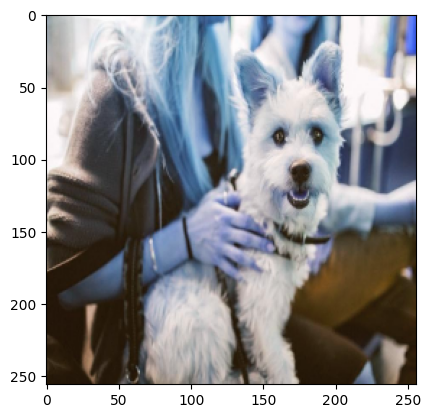

In [127]:
# the image needs to be resized to (256, 256) before it is sent as input to the neural network
dog = cv2.imread(img_path)
resized_img = tf.image.resize(dog, (256,256))
image = resized_img.numpy().astype(int)
plt.imshow(image)
plt.show()

In [128]:
resized_img.shape

TensorShape([256, 256, 3])

In [129]:
np.expand_dims(resized_img, 0).shape

(1, 256, 256, 3)

In [130]:
yhat = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 33ms/step


In [131]:
yhat

array([[0.9799079]], dtype=float32)

In [132]:
if yhat>0.5:
    print('Predicted class is DOG')
else:
    print('Predicted class is CAT')

Predicted class is DOG


### 5. Save the model

### Save the model

In [133]:
from tensorflow.keras.models import load_model

In [134]:
model.save(os.path.join('models', 'DogCat.h5'))

D:\python3.11.0\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [135]:
new_model = load_model(os.path.join('models', 'DogCat.h5'))

In [137]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 70ms/step


In [138]:
if yhat_new > 0.5:
    print("Predicted class is Dog")
else:
    print("Predicted class is Cat")

Predicted class is Dog
